In [26]:
from dependencies import *
import torch


In [27]:
checkpoint_quick_test= torch.load("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/checkpoints/model_checkpoint_UNet_01.pth")

In [28]:
#Checking the parameters and keys
print(type(checkpoint_quick_test))

<class 'dict'>


In [29]:
#Checking all model parameters 
for key in checkpoint_quick_test.keys():
    print(key)

epoch
model_state_dict
optimizer_state_dict
loss


In [30]:
#Importing UNet class from Unet.py

In [31]:
import sys
import os
sys.path.append("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/ML_models")

In [32]:
from UNet import UNet
from Downscaling_Dataset_Prep import DownscalingDataset
from Downscaling_Dataset_Prep import PairedDataset

In [33]:
model_instance= UNet(in_channels=2, out_channels=2)
model_instance.load_state_dict(checkpoint_quick_test["model_state_dict"])
model_instance.eval()

UNet(
  (Encoder1): Encoder_Block(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Encoder2): Encoder_Block(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

In [34]:
#Scaled datasets for testing :loading


In [35]:
precip_input = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/data/processed/Bicubic/Test/SCALED_features_precip_masked_bicubic_test.nc")
temp_input = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/data/processed/Bicubic/Test/SCALED_features_tas_masked_bicubic_test.nc")
precip_target = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/data/processed/Bicubic/Test/SCALED_targets_precip_masked_test.nc")
temp_target= xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/data/processed/Bicubic/Test/SCALED_targets_tas_masked_test.nc")

In [36]:
#Building the paired feature-target dataset; first loading individual and coverting them into images

In [12]:
precip_ds= DownscalingDataset(precip_input, precip_target, var_name_inputs="pr", var_name_targets="RhiresD")
temp_ds = DownscalingDataset(temp_input, temp_target, var_name_inputs='tas', var_name_targets='TabsD')


In [13]:
from torch.utils.data import DataLoader

In [14]:
#Now building paired dataset
paired_ds= PairedDataset(precip_ds,temp_ds)


A single prediction : not batch wise

In [24]:
#Predicting one single image pair
index=0
input_img, target_img=paired_ds[index]
input_img= input_img.unsqueeze(0)
model_instance.eval()
with torch.no_grad():
    output_img=model_instance(input_img)

output_img=output_img.squeeze(0)

Whats the time coordinate of this index?

In [25]:

corresponding_time_pr = precip_ds['time'].isel(time=index).values
corresponding_time_tas = temp_ds['time'].isel(time=index).values

print("Corresponding time (precip dataset):", corresponding_time_pr)
print("Corresponding time (temperature dataset):", corresponding_time_tas)


ValueError: Error parsing datetime string "time" at position 0

In [16]:
input_img=input_img.squeeze(0)

In [17]:
input_img.shape

torch.Size([2, 265, 370])

In [18]:
output_img.shape

torch.Size([2, 265, 370])

The channels were given in unison to the model. For visualisation , it has to be separated. I separate it here for both inpouts and outputs because they have to be plotted side by side for comparison


In [19]:
input_rhiresd= input_img[0,:,:]
input_tabsd= input_img[1,:,:]

In [20]:
predicted_rhiresd= output_img[0,:,:]
predicted_tabsd= output_img[1,:,:]

In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Plotting a single image : input and output image for rhiresd and tabsd side by side

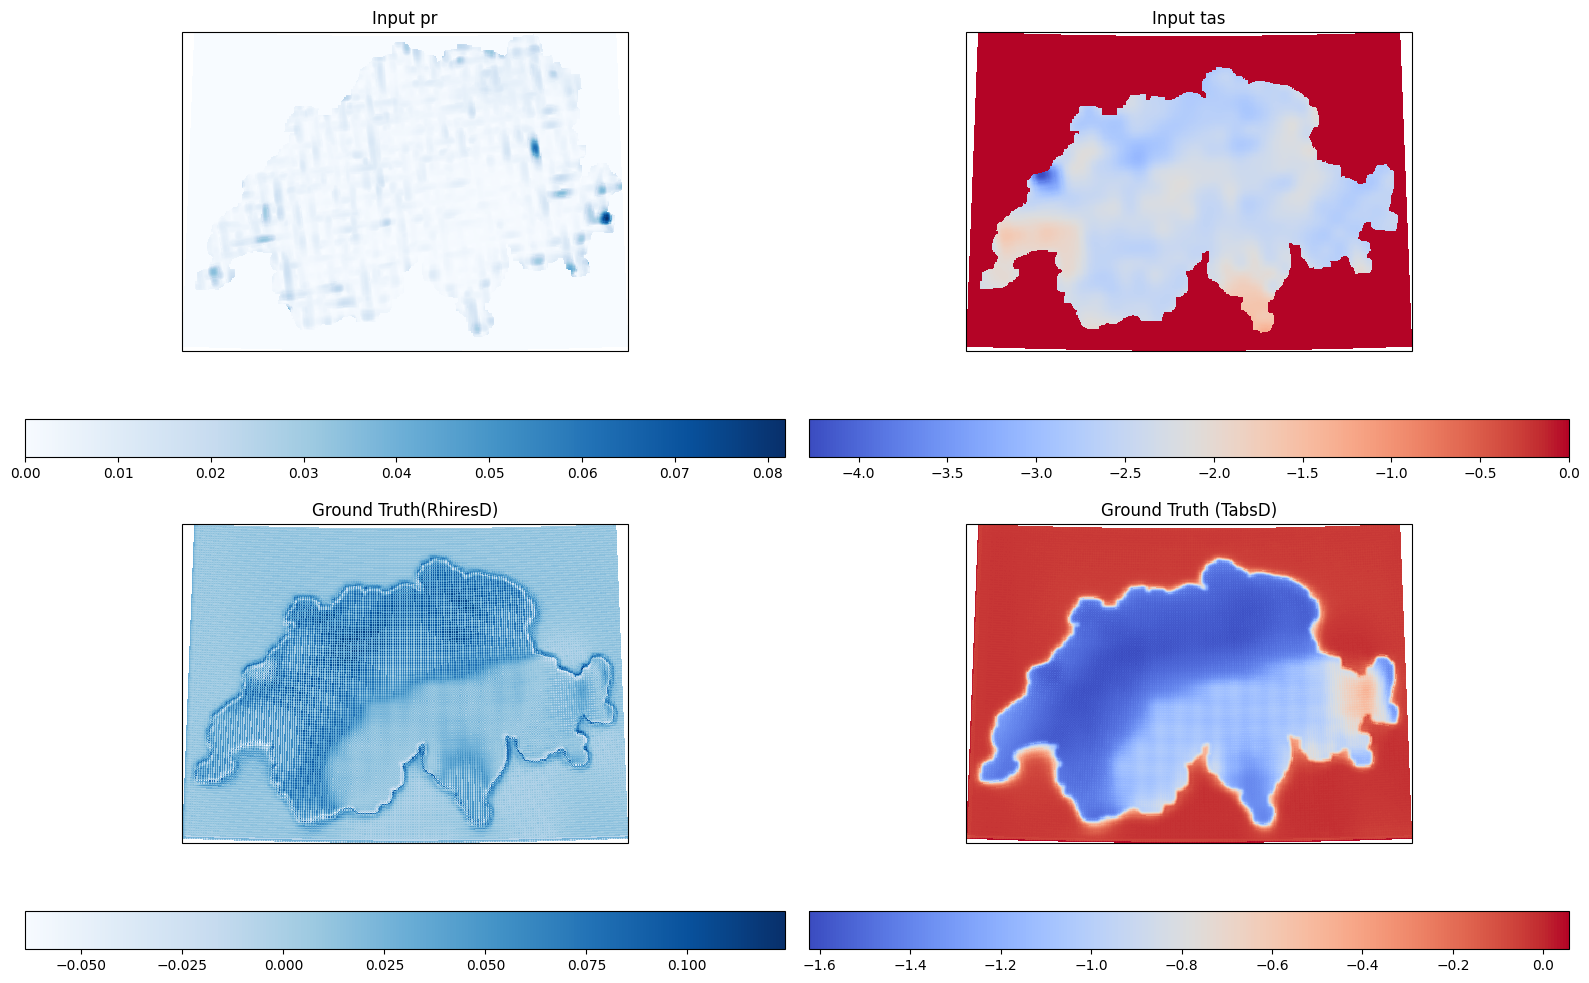

In [23]:
lon_min, lon_max = 5, 11
lat_min, lat_max = 45, 48

lons = np.linspace(lon_min, lon_max, input_rhiresd.shape[1])
lats = np.linspace(lat_min, lat_max, input_rhiresd.shape[0])
lon2d, lat2d = np.meshgrid(lons, lats)

lambert_proj = ccrs.LambertAzimuthalEqualArea(central_longitude=8, central_latitude=47)

fig, axes = plt.subplots(2, 2, figsize=(16, 10), subplot_kw={'projection': lambert_proj})

ax = axes[0, 0]
im = ax.pcolormesh(lon2d, lat2d, input_rhiresd.cpu(), cmap='Blues', shading='auto', transform=ccrs.PlateCarree())
ax.set_title('Input pr')
fig.colorbar(im, ax=ax, orientation='horizontal')

# Input Temperature
ax = axes[0, 1]
im = ax.pcolormesh(lon2d, lat2d, input_tabsd.cpu(), cmap='coolwarm', shading='auto', transform=ccrs.PlateCarree())
ax.set_title('Input tas')
fig.colorbar(im, ax=ax, orientation='horizontal')

# Predicted Precipitation
ax = axes[1, 0]
im = ax.pcolormesh(lon2d, lat2d, predicted_rhiresd.cpu(), cmap='Blues', shading='auto', transform=ccrs.PlateCarree())
ax.set_title('Ground Truth(RhiresD)')
fig.colorbar(im, ax=ax, orientation='horizontal')

# Predicted Temperature
ax = axes[1, 1]
im = ax.pcolormesh(lon2d, lat2d, predicted_tabsd.cpu(), cmap='coolwarm', shading='auto', transform=ccrs.PlateCarree())
ax.set_title('Ground Truth (TabsD)')
fig.colorbar(im, ax=ax, orientation='horizontal')

plt.tight_layout()
plt.show()


Predictions in batches with batch_size=32

In [ ]:
test_loader= DataLoader(paired_ds, batch_size=1, shuffle=False)
predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model_instance(inputs)
        predictions.append(outputs)

#Stacking predictions
predictions = torch.cat(predictions, dim=0) 

print(f"Final Predictions shape: {predictions.shape}")


KeyboardInterrupt: 